In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
ds = pd.read_excel('Data_Sample_AIC.xlsx', sheet_name = 'Online Retail')
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    54214 non-null  object        
 1   StockCode    54214 non-null  object        
 2   Description  54080 non-null  object        
 3   Quantity     54214 non-null  int64         
 4   InvoiceDate  54214 non-null  datetime64[ns]
 5   UnitPrice    54214 non-null  float64       
 6   CustomerID   40643 non-null  float64       
 7   Country      54214 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 3.3+ MB


1. Описание данных: что отражают, их качество и полнота, некорректности и аномалии

Описание данных по содержимому столбцов:
InvoiceNo: Номер счета/транзакции. Транзакции, связанные с отменой, обозначены "C" перед номером.
StockCode: уникальный код, состоящий из набора цифр и букв, обозначающих товар на складе.
Description: краткое описание товара.
Quantity: количество единиц товара, целое число.
InvoiceDate: дата и время транзакции до минут.
UnitPrice: Цена за единицу продукции, число с плавающей точкой.
CustomerID: уникальный идентификатор пользователя, совершившего транзакцию
Country: страна пользователя, допускаются записи без указанная страны
Полнота и качество данных:
В исходном датасете 54214 записи.
В данных присутствуют дублирующиеся записи (50 строк), которые возникли, возможно, из-за сбоя в работе программы учета.
В столбце с идентификатором пользователя 13571 пустых записей - это 25% от всех записей (после удаления дубликатов).
В столбце с описанием товара есть 134 пропуска, при этом у всех из них нулевая цена.
Всего есть 225 записей с нулевой ценой товара, почти все они при этом с пустым идентификатором пользователя. Возможно, так хранились данные о списанных товарах (выброшено, потеряно, испорчено, не продалось и т. д.).

In [ ]:
#очищенный в экселе от хаотичных и пустых (кроме пустых CustomerID) записей датасет:
ds1 = pd.read_excel('Data_Sample_AIC.xlsx', sheet_name = 'cleaR')
ds1 = ds1.drop_duplicates()
ds1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53943 entries, 0 to 53992
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    53943 non-null  object        
 1   StockCode    53943 non-null  object        
 2   Description  53943 non-null  object        
 3   Quantity     53943 non-null  int64         
 4   InvoiceDate  53943 non-null  datetime64[ns]
 5   month        53943 non-null  int64         
 6   UnitPrice    53943 non-null  float64       
 7   CustomerID   40593 non-null  float64       
 8   Country      53943 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 4.1+ MB


In [ ]:
#количество пропусков в стобце чистого датасета:
ds1.isna().mean() * 53943

InvoiceNo          0.0
StockCode          0.0
Description        0.0
Quantity           0.0
InvoiceDate        0.0
month              0.0
UnitPrice          0.0
CustomerID     13350.0
Country            0.0
dtype: float64

2. Описание применённого подхода к анализу данных: ограничения, накладываемые данными, и соответствующие интерпретации допущения.

Положим, что информация о транзакциях с испорченными, потерянными и бесплатными товарами не является ценной для анализа и составления метрик, отвечающих на вопросы бизнеса. Тогда записи с такой информацией должны быть удалены из датасета: удалены строки, для которых в Description описано всё что угодно, кроме описания товара. Далее удалены строки с нулевой ценой, для которых CustomerID нулевое (нет больше покупателя и нет цены - считаем, что не было и транзакции).
В очищеном от некорректной и бесполезной информации датасете осталось 53943 записи. Пустые записи остались только в столбце CustomerID (всего 13350), но эти строки можно анализировать, допуская, что каждому InvoiceNo соответствует уникальный пользователь. От такого допущения результаты анализа будут искажены не существенно, учитывая, что пустой CustomerID - скорее всего, связан с удаленным аккаунтом пользователя и мы бы всё равно не записали его в постоянные покупатели. Будем считать, что НЕ пустой CustomerID - активный покупатель (зарегистрировался и еще не удалил аккаунт).
Сложность с выявлением постоянных покупателей в данном датасете еще в том, что CustomerID скорее всего создается автоматически при регистрации аккаунта, а человек может создать 2 аккаунта, или удалять и создавать их каждый день.
При расчетах будет применен вероятный факт, что одинаковые значения в столбце InvoiceNo составляют одну транзакцию (одну покупку пользователя).
Будем предполагать, что UnitPrice указана в евро.
Также будем предполагать, что до 2019 года магазина не существовало, а сейчас начало 2021 года.

3. Описание бизнес-заказчика, его гипотетических болей и целей развития бизнеса.
Заказчик - новичок в сфере торговли, мечтающий зарабатывать много на перепродаже товаров из Китая.
Его главной болью является доход, который не растет. Всему виной, как он считает, невозможность планирования бюджета компании, из-за чего возникают сложности с установкой оптимальных цен на продукцию, установлением соответствующей зарплаты сотрудникам. Как следствие, нерешительность при расширении ассортимента товаров или повышении цен, возможные избыточные затраты на персонал.
В целях - быстро растущий доход и расширение бизнеса в плане ассортимента и покупателей.
Начать достигать цель заказчик планирует со следующих задач:
- уменьшение количества отмен транзакций
- увеличение среднего чека
- увеличение количества постоянных покупателей

4. Описание стейкхолдеров отчёта с обоснованием выбранных метрик (системы метрик).

Отчет необходимо сформировать в формате, в котором заказчик сможет с легкостью его просмотреть без изучения дополнительной профессиональной информации. Метрики должны помогать решать поставленные задачи. Отчет должен быть понятен аналитику из компании заказчика, метрики должны иметь названия, а визуализации должны быть в редактируемом формате. В качестве метрик нужно предоставить графики или числа (абсолютные или относителные).

Метрики, подходящие для текущих задач и обоснование:
- контроль процента отмененных транзакций (метрика для мониторинга, отвечающая задаче уменьшить количество отмен, которые могут быть, например, связаны с неудобностью сайта)
- средний чек с течением времени (метрика поможет знать текущую ситуацию и связывать изменения с сезонностью)
- среднее количество транзакций на одного покупателя из активных (чтобы судить о привлекательности цен и широте/интересности ассортимента)
- количество покупателей, купивших в магазине более раза (мониторинг процесса генерации постоянных покупателей)

In [ ]:
def cancel(InvoiceNo):
    if str(InvoiceNo).startswith("C") == True :
        return InvoiceNo

ds1['Canceled'] = ds1['InvoiceNo'].apply(cancel)
ds1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,month,UnitPrice,CustomerID,Country,Canceled
0,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2019-12-01 08:26:00,12,3.39,17850.0,United Kingdom,None
1,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2019-12-01 08:34:00,12,1.69,13047.0,United Kingdom,None
2,536367,21755,LOVE BUILDING BLOCK WORD,3,2019-12-01 08:34:00,12,5.95,13047.0,United Kingdom,None
3,536368,22914,BLUE COAT RACK PARIS FASHION,3,2019-12-01 08:34:00,12,4.95,13047.0,United Kingdom,None
4,536373,84406B,CREAM CUPID HEARTS COAT HANGER,8,2019-12-01 09:02:00,12,2.75,17850.0,United Kingdom,None


In [ ]:
#1. процент отмен транзакций, %:
round(ds1.Canceled.count() / ds1.InvoiceNo.count() * 100 , 3)

1.778

In [ ]:
#будем считать чек только по положительным стоимостям, без отмен. И только за 2020 год
ds2 = pd.read_excel('Data_Sample_AIC.xlsx', sheet_name = 'plus')
ds2 = ds2.drop_duplicates()

In [ ]:
#добавление столбца со стоимостью
ds2['Cost'] =  ds2['Quantity'] * ds2['UnitPrice']
ds2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,month,UnitPrice,CustomerID,Country,Cost
0,539993,20682,RED RETROSPOT CHILDRENS UMBRELLA,6,2020-01-04 10:00:00,1,3.25,13313.0,United Kingdom,19.5
1,540003,22193,RED DINER WALL CLOCK,2,2020-01-04 10:37:00,1,8.50,16875.0,United Kingdom,17.0
2,540003,84970L,SINGLE HEART ZINC T-LIGHT HOLDER,12,2020-01-04 10:37:00,1,0.95,16875.0,United Kingdom,11.4
3,540005,85062,PEARL CRYSTAL PUMPKIN T-LIGHT HLDR,6,2020-01-04 10:38:00,1,1.65,17315.0,United Kingdom,9.9
4,540005,21615,4 LAVENDER BOTANICAL DINNER CANDLES,12,2020-01-04 10:38:00,1,1.25,17315.0,United Kingdom,15.0


In [ ]:
#2. рассчет среднего чека за каждый месяц:

#группировка по транзакции и суммирование стоимостей по одной транзакции, чтобы узнать стоимость одного-каждого чека
average_bill = ds2.groupby(['month', 'InvoiceNo']).agg({'Cost': ['sum']}).reset_index()
#группировка с подсчетом количества транзакций
ave = average_bill[['month', 'InvoiceNo']].groupby(['month']).count().reset_index()
#с подсчетом суммы всех стоимостей за месяц
rage = average_bill[['month', 'Cost']].groupby(['month']).sum().reset_index()
#общая таблица
average = ave.merge(rage, on = 'month', how = 'left')
average

<ipython-input-9-06787c269cd8>:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ave = average_bill[['month', 'InvoiceNo']].groupby(['month']).count().reset_index()
<ipython-input-9-06787c269cd8>:8: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  rage = average_bill[['month', 'Cost']].groupby(['month']).sum().reset_index()
<ipython-input-9-06787c269cd8>:10: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  average = ave.merge(rage, on = 'month', how = 'left')


,month,InvoiceNo,Cost
,,,sum
0,1,776,66011.140
1,2,769,50644.480
2,3,1015,77140.450
3,4,867,51989.050
4,5,1128,77522.290
5,6,1051,77608.610
6,7,1021,76442.380
7,8,938,77884.510
8,9,1349,101596.411


In [ ]:
'''
writer = pd.ExcelWriter('average.xlsx')
average.to_excel(writer, 'Query', index= True)
writer.save()
'''

"\nwriter = pd.ExcelWriter('average.xlsx')\naverage.to_excel(writer, 'Query', index= True)\nwriter.save()\n"

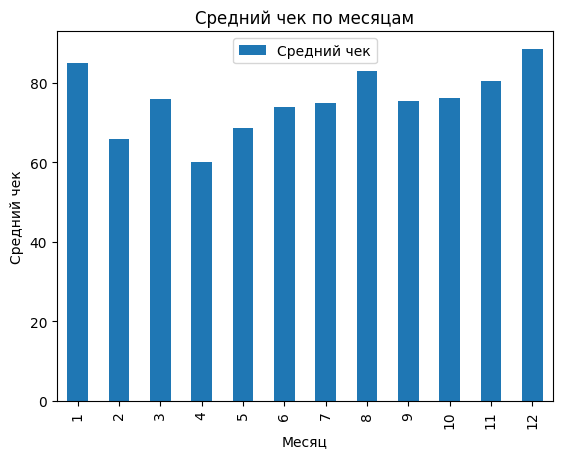

In [ ]:
ave = pd.read_excel('Data_Sample_AIC.xlsx', sheet_name = 'ave')
ave[['month', 'ave_bill']].plot(kind='bar',
                    x='month',
                    y='ave_bill',
                    xlabel='Месяц',
                    ylabel='Средний чек',
                    title='Средний чек по месяцам')
plt.legend(['Средний чек'])
plt.rcParams['figure.figsize'] = [11, 5]
plt.show()

In [ ]:
#3. среднее количество транзакций на одного покупателя

ds3 = pd.read_excel('Data_Sample_AIC.xlsx', sheet_name = 'cleaR_m_activ')
ds3.head()

,InvoiceNo,StockCode,Description,Quantity,month,UnitPrice,CustomerID
0,542237,22725,ALARM CLOCK BAKELIKE CHOCOLATE,4,1,3.75,12347
1,542237,22423,REGENCY CAKESTAND 3 TIER,3,1,12.75,12347
2,549222,22371,AIRLINE BAG VINTAGE TOKYO 78,4,4,4.25,12347
3,549222,84559A,3D SHEET OF DOG STICKERS,12,4,0.85,12347
4,549222,22497,SET OF 2 TINS VINTAGE BATHROOM,4,4,4.25,12347


In [ ]:
customer_t = ds3[['month', 'InvoiceNo', 'CustomerID']].groupby(['month', 'CustomerID']).agg({'InvoiceNo': ['nunique']}).reset_index()
customer_t.head(20)
#видно, что в среднем 1 покупатель совершает за месяц одну транзакцию

,month,CustomerID,InvoiceNo
,,,nunique
0,1,12347,1
1,1,12356,1
2,1,12359,1
3,1,12377,1
4,1,12383,1
5,1,12393,2
6,1,12413,1
7,1,12415,1
8,1,12422,1


In [ ]:
# значит имеет смысл считать среднее количество транзакций на одного покупателя только за год (2020)

customer_t = ds3[['InvoiceNo', 'CustomerID']].groupby(['CustomerID']).agg({'InvoiceNo': ['nunique']}).reset_index()
#customer_t.head(20)

#результат
invo_na_custo = customer_t.InvoiceNo.sum()/customer_t.CustomerID.count()
invo_na_custo

nunique    3.41925
dtype: float64

In [ ]:
#столько пришло на счет магазина за 2020 год:
ds2.Cost.sum()

976460.0210000001

In [ ]:
#за 2020 в магазине сделали покупку столько раз:
customer_t.InvoiceNo.sum()

nunique    12682
dtype: int64

In [ ]:
#4. количество покупателей, купивших в магазине более раза

customer_t.columns = [tup[1] if tup[1] else tup[0] for tup in customer_t.columns]
customer_t.head()

,CustomerID,nunique
0,12347,4
1,12348,1
2,12349,1
3,12350,1
4,12352,6


In [ ]:
'''
writer = pd.ExcelWriter('customer_t.xlsx')
customer_t.to_excel(writer, 'cu', index= True)
writer.save()
'''

"\nwriter = pd.ExcelWriter('customer_t.xlsx')\ncustomer_t.to_excel(writer, 'cu', index= True)\nwriter.save()\n"

In [ ]:
#датасет с постоянными покупателями
permanent = pd.read_excel('Data_Sample_AIC.xlsx', sheet_name = 'permanent')
permanent.head()

,CustomerID,Invoices
0,12347,4
1,12352,6
2,12356,2
3,12359,4
4,12360,3


In [ ]:
#количество постоянных покупателей в 2020
permanent.CustomerID.count()

2216

5. Рекомендации по модели данных бизнес-заказчика: что вы считаете важным отслеживать в дополнение к тому, что уже есть в датасете.

Чтобы данные было проще интерпретировать и анализировать:
1) Необходимо деление транзакций на категории в отдельном столбце. Данные о том, что товар утерян/испорчен, данные о подарке покупателю, о ошибке и т. д. не должны храниться в одном столбце вместе с описанием проданного/отмененного товара.
2) В датасет можно включить данные о статусе аккаунта пользователя (активен/удален).
3) В идеале, включить в датасет более надежную идентификацию пользователя, кроме CustomerID, например, номер телефона, адрес (для выявления при анализе того, что один пользователь это один CustomerID, а не два. И более корректного подсчета постоянных покупателей).

6. Сформулированные выводы и рекомендации для бизнес-заказчика.

Как должны меняться метрики для достижения цели: процент отмененных транзакций должен уменьшаться; средний чек должен увеличиваться с течением времени; количество постоянных покупателей за год должно увеличиваться; среднее количество транзакций на одного покупателя должно расти.
Для формирования оптимальных цен необходимо изучать цены конкурентов и устанавливать их выше среднего, учитывая, что магазинов подобной тематики не много, например, в пределах страны (а сновные покупатели - из Великобритании).
Из-за специфики магазина, за месяц один покупатель делает в среднем одну покупку в магазине. Многие сделали одну покупку за всё время. Возможно, если нет цели продавать товары конкретно такой категории, стоит полностью сменить тематику товара для увеличения дохода.
Также, из-за малого количества покупок и товаров в течение месяца, данных для предоставления "говорящих" метрик не достаточно. А данные, проанализированные в интервале одного года, и абсолютные метрики, рассчитанные на их основе, могут быть мало информативными.